# Train Inverse Safety Model
# 
This notebook trains the crash classifier and implements inverse safety scoring.
## 
## Steps:
## 1. Load and prepare VRU crash data
## 2. Engineer features
## 3. Create synthetic 'safe driving' samples
## 4. Train crash classifier (XGBoost/Random Forest)
## 5. Extract decision boundaries
## 6. Compute safety scores
## 7. Generate 'good driver profile'

In [1]:
# Test if output is working
print("=" * 60)
print("STARTING IMPORTS - If you see this, output is working!")
print("=" * 60)

import sys
sys.path.append('../src')

print("\n[Step 1/10] Importing pandas...")
import pandas as pd
print("            ✓ pandas loaded")

print("[Step 2/10] Importing numpy...")
import numpy as np
print("            ✓ numpy loaded")

print("[Step 3/10] Importing matplotlib...")
import matplotlib.pyplot as plt
print("            ✓ matplotlib loaded")

print("[Step 4/10] Importing seaborn...")
import seaborn as sns
print("            ✓ seaborn loaded")

print("[Step 5/10] Importing scikit-learn...")
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
print("            ✓ scikit-learn loaded")

print("[Step 6/10] Configuring warnings...")
import warnings
warnings.filterwarnings('ignore')
print("            ✓ warnings configured")

# Custom modules - these might be slower
print("[Step 7/10] Importing CRSSDataLoader...")
from data_loader import CRSSDataLoader
print("            ✓ CRSSDataLoader loaded")

print("[Step 8/10] Importing FeatureEngineer...")
from feature_engineering import FeatureEngineer
print("            ✓ FeatureEngineer loaded")

print("[Step 9/10] Importing SafetyScoreModel...")
from models import SafetyScoreModel
print("            ✓ SafetyScoreModel loaded")

print("[Step 10/10] Setting plot configuration...")
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("            ✓ Configuration set")

# Import tqdm for later use
from tqdm.notebook import tqdm

print("\n" + "=" * 60)
print("✅ ALL IMPORTS COMPLETE!")
print("=" * 60)
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {plt.matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")
print("=" * 60)

STARTING IMPORTS - If you see this, output is working!

[Step 1/10] Importing pandas...
            ✓ pandas loaded
[Step 2/10] Importing numpy...
            ✓ numpy loaded
[Step 3/10] Importing matplotlib...
            ✓ matplotlib loaded
[Step 4/10] Importing seaborn...
            ✓ seaborn loaded
[Step 5/10] Importing scikit-learn...
            ✓ scikit-learn loaded
[Step 6/10] Configuring warnings...
            ✓ warnings configured
[Step 7/10] Importing CRSSDataLoader...
            ✓ CRSSDataLoader loaded
[Step 8/10] Importing FeatureEngineer...
            ✓ FeatureEngineer loaded
[Step 9/10] Importing SafetyScoreModel...
            ✓ SafetyScoreModel loaded
[Step 10/10] Setting plot configuration...
            ✓ Configuration set

✅ ALL IMPORTS COMPLETE!
pandas version: 2.3.3
numpy version: 2.3.5
matplotlib version: 3.10.8
seaborn version: 0.13.2


## 1. Load VRU Crash Data

In [2]:
# Load crash data
import logging

# Enable logging to see data loading progress
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

loader = CRSSDataLoader(data_dir='../CRSS_Data')
print("🔄 Loading VRU crash data...")
print("   This may take 1-2 minutes as we load 8 years of CRSS data...")
print("   (417K accidents, 735K vehicles, 1M+ persons, 38K pbtype records)")
print()

# Load complete dataset with VRU crashes
vru_crashes_ids = loader.get_vru_crashes()

print(f"\n✅ Loaded {len(vru_crashes_ids):,} VRU crash case numbers")

# Now load the full accident data for these crashes
print("\n🔄 Loading full crash details...")
full_data = loader.load_complete_dataset()
accident_data = full_data['accident']
person_data = full_data['person']

# Filter to VRU crashes only
vru_crashes = accident_data[accident_data['CASENUM'].isin(vru_crashes_ids)].copy()

print(f"\n✅ VRU Crash Dataset Ready!")
print(f"   Total VRU crashes: {len(vru_crashes):,}")
print(f"   Features/Columns: {vru_crashes.shape[1]}")
print(f"   Sample columns: {list(vru_crashes.columns[:20])}...")
print(f"\n   Data shape: {vru_crashes.shape}")

# Store person_data for later use in feature engineering
print("\n💡 Person data also loaded for VRU feature engineering")

INFO:data_loader:Loading complete CRSS dataset...
INFO:data_loader:Loading accident data for 2016 from ACCIDENT.CSV
INFO:data_loader:Loading accident data for 2017 from ACCIDENT.CSV


🔄 Loading VRU crash data...
   This may take 1-2 minutes as we load 8 years of CRSS data...
   (417K accidents, 735K vehicles, 1M+ persons, 38K pbtype records)



INFO:data_loader:Loading accident data for 2018 from ACCIDENT.csv
INFO:data_loader:Loading accident data for 2019 from accident.CSV
INFO:data_loader:Loading accident data for 2020 from accident.csv
INFO:data_loader:Loading accident data for 2021 from accident.csv
INFO:data_loader:Loading accident data for 2022 from accident.csv
INFO:data_loader:Loading accident data for 2023 from accident.csv
INFO:data_loader:Combined accident data: 417,335 records from 8 years
INFO:data_loader:Loading vehicle data for 2016 from VEHICLE.CSV
INFO:data_loader:Loading vehicle data for 2017 from VEHICLE.CSV
INFO:data_loader:Loading vehicle data for 2018 from VEHICLE.csv
INFO:data_loader:Loading vehicle data for 2019 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2020 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2021 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2022 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2023 from vehicle.csv
INFO:data_loader:Combi


✅ Loaded 35,314 VRU crash case numbers

🔄 Loading full crash details...


INFO:data_loader:Loading accident data for 2018 from ACCIDENT.csv
INFO:data_loader:Loading accident data for 2019 from accident.CSV
INFO:data_loader:Loading accident data for 2020 from accident.csv
INFO:data_loader:Loading accident data for 2021 from accident.csv
INFO:data_loader:Loading accident data for 2022 from accident.csv
INFO:data_loader:Loading accident data for 2023 from accident.csv
INFO:data_loader:Combined accident data: 417,335 records from 8 years
INFO:data_loader:Loading vehicle data for 2016 from VEHICLE.CSV
INFO:data_loader:Loading vehicle data for 2017 from VEHICLE.CSV
INFO:data_loader:Loading vehicle data for 2018 from VEHICLE.csv
INFO:data_loader:Loading vehicle data for 2019 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2020 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2021 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2022 from vehicle.csv
INFO:data_loader:Loading vehicle data for 2023 from vehicle.csv
INFO:data_loader:Combi


✅ VRU Crash Dataset Ready!
   Total VRU crashes: 35,314
   Features/Columns: 90
   Sample columns: ['CASENUM', 'PSU', 'PJ', 'STRATUM', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS', 'PERMVIT', 'PERNOTMVIT', 'NUM_INJ', 'MONTH', 'YEAR', 'DAY_WEEK', 'HOUR', 'MINUTE', 'HARM_EV', 'ALCOHOL', 'MAX_SEV', 'MAN_COLL']...

   Data shape: (35314, 90)

💡 Person data also loaded for VRU feature engineering


## 2. Engineer Features

In [3]:
# Initialize feature engineer
fe = FeatureEngineer()

# Create features with progress indication
print("🔄 Engineering features...")
print()

print("   → Temporal features (time, day, season)...")
vru_crashes = fe.create_temporal_features(vru_crashes)

print("   → Environmental features (weather, lighting)...")
vru_crashes = fe.create_environmental_features(vru_crashes)

print("   → Location features (road type, area)...")
vru_crashes = fe.create_location_features(vru_crashes)

print("   → VRU-specific features (pedestrian/cyclist interactions)...")
vru_crashes = fe.create_vru_features(vru_crashes, person_data)

print("   → Interaction features (combined risk factors)...")
vru_crashes = fe.create_interaction_features(vru_crashes)

print(f"\n✅ Feature engineering complete!")
print(f"   Total features: {vru_crashes.shape[1]}")
print(f"   Feature types: {vru_crashes.dtypes.value_counts().to_dict()}")

INFO:feature_engineering:Created temporal features


INFO:feature_engineering:Created environmental features
INFO:feature_engineering:Created location features


🔄 Engineering features...

   → Temporal features (time, day, season)...
   → Environmental features (weather, lighting)...
   → Location features (road type, area)...
   → VRU-specific features (pedestrian/cyclist interactions)...


INFO:feature_engineering:Created VRU features
INFO:feature_engineering:Created interaction features


   → Interaction features (combined risk factors)...

✅ Feature engineering complete!
   Total features: 105
   Feature types: {dtype('int64'): 58, dtype('O'): 38, dtype('float64'): 9}


## 3. Create Target Variable
## 
## For inverse modeling, we need both crash samples (1) and safe driving samples (0).
## We'll create synthetic safe driving samples by modifying crash conditions.

In [4]:
def create_safe_driving_samples(crash_df: pd.DataFrame, n_samples: int = None) -> pd.DataFrame:
    """
    Create synthetic safe driving samples by modifying crash conditions.
    
    Strategy:
    - Take crash samples
    - Modify high-risk features to safer values
    - Label as 'safe' (0)
    """
    if n_samples is None:
        n_samples = len(crash_df)
    
    # Sample crashes to modify
    safe_samples = crash_df.sample(n=min(n_samples, len(crash_df)), replace=True).copy()
    
    # Modify high-risk features to safer values
    # 1. Reduce night driving
    if 'IS_NIGHT' in safe_samples.columns:
        safe_samples.loc[safe_samples.sample(frac=0.7).index, 'IS_NIGHT'] = 0
    
    # 2. Improve lighting conditions
    if 'POOR_LIGHTING' in safe_samples.columns:
        safe_samples.loc[safe_samples.sample(frac=0.8).index, 'POOR_LIGHTING'] = 0
    
    # 3. Reduce adverse weather
    if 'ADVERSE_WEATHER' in safe_samples.columns:
        safe_samples.loc[safe_samples.sample(frac=0.9).index, 'ADVERSE_WEATHER'] = 0
    
    # 4. Reduce speed (if available)
    if 'SPEED_REL' in safe_samples.columns:
        safe_samples['SPEED_REL'] = safe_samples['SPEED_REL'].clip(upper=3)
    
    # 5. Improve road conditions
    if 'ROAD_COND' in safe_samples.columns:
        safe_samples.loc[safe_samples.sample(frac=0.85).index, 'ROAD_COND'] = 1  # 1 = dry
    
    return safe_samples

# Create safe driving samples
print("Creating safe driving samples...")
safe_samples = create_safe_driving_samples(vru_crashes, n_samples=len(vru_crashes))

# Add target variable
vru_crashes['TARGET'] = 1  # Crash
safe_samples['TARGET'] = 0  # Safe

# Combine
full_dataset = pd.concat([vru_crashes, safe_samples], ignore_index=True)

print(f"\nDataset composition:")
print(f"  Crash samples: {(full_dataset['TARGET'] == 1).sum()}")
print(f"  Safe samples: {(full_dataset['TARGET'] == 0).sum()}")
print(f"  Total: {len(full_dataset)}")

Creating safe driving samples...

Dataset composition:
  Crash samples: 35314
  Safe samples: 35314
  Total: 70628


## 4. Select Features for Modeling

In [5]:
# Select numeric features for modeling
numeric_cols = full_dataset.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and target
exclude_cols = ['CASENUM', 'PSU', 'YEAR', 'TARGET', 'VEH_NO', 'PER_NO']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Selected {len(feature_cols)} features for modeling")
print(f"\nTop 20 features:")
for i, col in enumerate(feature_cols[:20], 1):
    print(f"  {i}. {col}")

Selected 64 features for modeling

Top 20 features:
  1. PJ
  2. STRATUM
  3. VE_TOTAL
  4. VE_FORMS
  5. PVH_INVL
  6. PEDS
  7. PERMVIT
  8. PERNOTMVIT
  9. NUM_INJ
  10. MONTH
  11. DAY_WEEK
  12. HOUR
  13. MINUTE
  14. HARM_EV
  15. ALCOHOL
  16. MAX_SEV
  17. MAN_COLL
  18. RELJCT1
  19. RELJCT2
  20. TYP_INT


## 5. Train Models
## 
## We'll train three models and compare:
## 1. Random Forest
## 2. XGBoost
## 3. Gradient Boosting

In [6]:
# Prepare data
X = full_dataset[feature_cols].fillna(0)
y = full_dataset['TARGET']

print(f"Training data: {X.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

Training data: (70628, 64)
Class distribution: {1: 35314, 0: 35314}



TRAINING RANDOM FOREST (3 ITERATIONS)

🔄 Training 3 different Random Forest models...
   Finding the best configuration through random seed variation



RF Training:   0%|          | 0/3 [00:00<?]

INFO:models:Initialized random_forest model
INFO:models:
=== Training Safety Model ===
INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7287
INFO:models:Test accuracy: 0.7196
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8306


              precision    recall  f1-score   support

           0       0.65      0.97      0.78      7063
           1       0.94      0.47      0.63      7063

    accuracy                           0.72     14126
   macro avg       0.79      0.72      0.70     14126
weighted avg       0.79      0.72      0.70     14126



INFO:models:Cross-validation scores: [0.72161756 0.72630741 0.72088496 0.72283186 0.72168142]
INFO:models:CV mean: 0.7227 (+/- 0.0038)
INFO:models:
=== Training Complete ===
INFO:models:Initialized random_forest model
INFO:models:
=== Training Safety Model ===
INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7291
INFO:models:Test accuracy: 0.7221
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8304


              precision    recall  f1-score   support

           0       0.65      0.97      0.78      7063
           1       0.94      0.48      0.63      7063

    accuracy                           0.72     14126
   macro avg       0.79      0.72      0.70     14126
weighted avg       0.79      0.72      0.70     14126



INFO:models:Cross-validation scores: [0.72090965 0.7191399  0.71725664 0.72336283 0.72902655]
INFO:models:CV mean: 0.7219 (+/- 0.0082)
INFO:models:
=== Training Complete ===
INFO:models:Initialized random_forest model
INFO:models:
=== Training Safety Model ===
INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7289
INFO:models:Test accuracy: 0.7246
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8359


              precision    recall  f1-score   support

           0       0.65      0.97      0.78      7063
           1       0.94      0.48      0.64      7063

    accuracy                           0.72     14126
   macro avg       0.79      0.72      0.71     14126
weighted avg       0.79      0.72      0.71     14126



INFO:models:Cross-validation scores: [0.72285638 0.72029024 0.72106195 0.71884956 0.7180531 ]
INFO:models:CV mean: 0.7202 (+/- 0.0034)
INFO:models:
=== Training Complete ===



📊 Random Forest Training Summary:
   Best Test Accuracy: 0.7246 (Iteration 3)
   Mean Test Accuracy: 0.7221 (±0.0025)
   Best ROC AUC: 0.8358512590985252


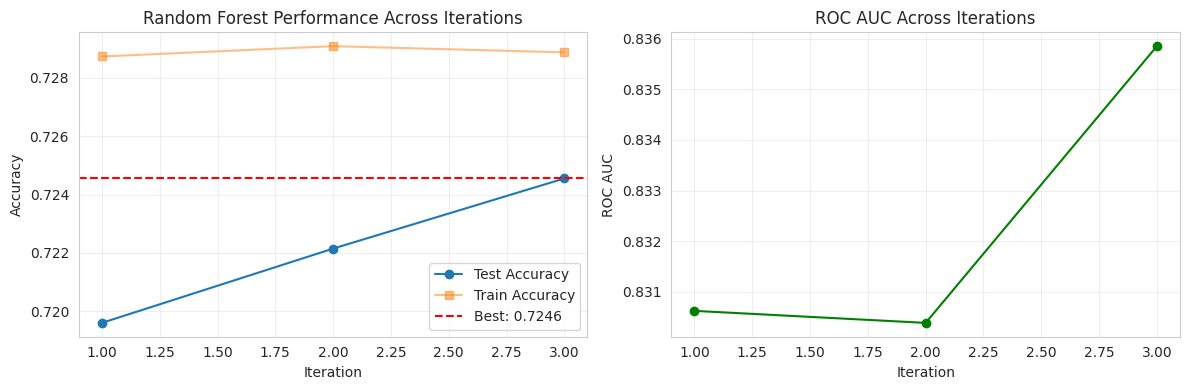


✅ Best Random Forest Model Selected!


In [7]:
# Train Random Forest with multiple iterations
print("\n" + "="*60)
print("TRAINING RANDOM FOREST (3 ITERATIONS)")
print("="*60)

n_iterations = 3
rf_results = []
best_rf_model = None
best_rf_score = 0

print(f"\n🔄 Training {n_iterations} different Random Forest models...")
print("   Finding the best configuration through random seed variation\n")

# Progress bar for iterations
with tqdm(total=n_iterations, desc="RF Training", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
    for iteration in range(1, n_iterations + 1):
        # Train with different random seed
        rf_model = SafetyScoreModel(model_type='random_forest', random_state=iteration*42)
        rf_model.feature_names = feature_cols
        rf_metrics = rf_model.train(X, y, test_size=0.2, validate=True)
        
        # Track results
        rf_results.append({
            'iteration': iteration,
            'train_acc': rf_metrics['train_accuracy'],
            'test_acc': rf_metrics['test_accuracy'],
            'roc_auc': rf_metrics.get('roc_auc', 0),
            'cv_mean': rf_metrics.get('cv_mean', 0)
        })
        
        # Keep best model
        if rf_metrics['test_accuracy'] > best_rf_score:
            best_rf_score = rf_metrics['test_accuracy']
            best_rf_model = rf_model
            best_rf_metrics = rf_metrics
            pbar.set_postfix_str(f"✨ Best: {best_rf_score:.4f}")
        else:
            pbar.set_postfix_str(f"Current: {rf_metrics['test_accuracy']:.4f}")
        
        pbar.update(1)

# Show results summary
rf_results_df = pd.DataFrame(rf_results)
print(f"\n📊 Random Forest Training Summary:")
print(f"   Best Test Accuracy: {best_rf_score:.4f} (Iteration {rf_results_df.loc[rf_results_df['test_acc'].idxmax(), 'iteration']:.0f})")
print(f"   Mean Test Accuracy: {rf_results_df['test_acc'].mean():.4f} (±{rf_results_df['test_acc'].std():.4f})")
print(f"   Best ROC AUC: {best_rf_metrics.get('roc_auc', 'N/A')}")

# Plot performance across iterations
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rf_results_df['iteration'], rf_results_df['test_acc'], marker='o', label='Test Accuracy')
plt.plot(rf_results_df['iteration'], rf_results_df['train_acc'], marker='s', alpha=0.5, label='Train Accuracy')
plt.axhline(y=best_rf_score, color='r', linestyle='--', label=f'Best: {best_rf_score:.4f}')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Random Forest Performance Across Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(rf_results_df['iteration'], rf_results_df['roc_auc'], marker='o', color='green')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Across Iterations')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Best Random Forest Model Selected!")


TRAINING XGBOOST (3 ITERATIONS)

🔄 Training 3 different XGBoost models...
   Finding the best configuration through random seed variation



XGB Training:   0%|          | 0/3 [00:00<?]

INFO:models:Initialized xgboost model
INFO:models:
=== Training Safety Model ===
INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7563
INFO:models:Test accuracy: 0.7056
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8295


              precision    recall  f1-score   support

           0       0.69      0.76      0.72      7063
           1       0.73      0.65      0.69      7063

    accuracy                           0.71     14126
   macro avg       0.71      0.71      0.70     14126
weighted avg       0.71      0.71      0.70     14126



INFO:models:Cross-validation scores: [0.70622069 0.70887532 0.70823009 0.70185841 0.70920354]
INFO:models:CV mean: 0.7069 (+/- 0.0054)
INFO:models:
=== Training Complete ===
INFO:models:Initialized xgboost model
INFO:models:
=== Training Safety Model ===
INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7604
INFO:models:Test accuracy: 0.6993
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8260


              precision    recall  f1-score   support

           0       0.70      0.71      0.70      7063
           1       0.70      0.69      0.70      7063

    accuracy                           0.70     14126
   macro avg       0.70      0.70      0.70     14126
weighted avg       0.70      0.70      0.70     14126



INFO:models:Cross-validation scores: [0.70878683 0.69852225 0.70256637 0.70778761 0.71150442]
INFO:models:CV mean: 0.7058 (+/- 0.0093)
INFO:models:
=== Training Complete ===
INFO:models:Initialized xgboost model
INFO:models:
=== Training Safety Model ===
INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7587
INFO:models:Test accuracy: 0.7022
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8279


              precision    recall  f1-score   support

           0       0.69      0.72      0.71      7063
           1       0.71      0.68      0.70      7063

    accuracy                           0.70     14126
   macro avg       0.70      0.70      0.70     14126
weighted avg       0.70      0.70      0.70     14126



INFO:models:Cross-validation scores: [0.7090523  0.70790196 0.70814159 0.70185841 0.70690265]
INFO:models:CV mean: 0.7068 (+/- 0.0051)
INFO:models:
=== Training Complete ===



📊 XGBoost Training Summary:
   Best Test Accuracy: 0.7056 (Iteration 1)
   Mean Test Accuracy: 0.7024 (±0.0032)
   Best ROC AUC: 0.8295285995146251


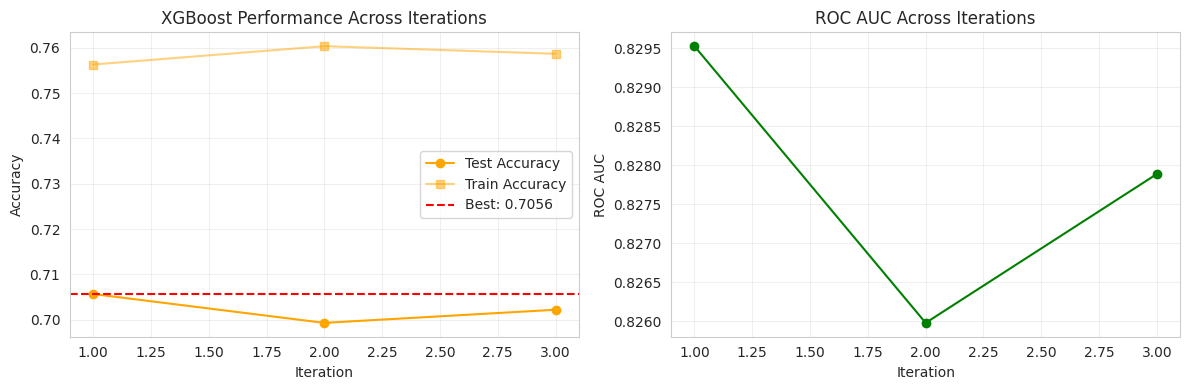


✅ Best XGBoost Model Selected!


In [8]:
# Train XGBoost with multiple iterations
print("\n" + "="*60)
print("TRAINING XGBOOST (3 ITERATIONS)")
print("="*60)

n_iterations = 3
xgb_results = []
best_xgb_model = None
best_xgb_score = 0

print(f"\n🔄 Training {n_iterations} different XGBoost models...")
print("   Finding the best configuration through random seed variation\n")

# Progress bar for iterations
with tqdm(total=n_iterations, desc="XGB Training", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
    for iteration in range(1, n_iterations + 1):
        # Train with different random seed
        xgb_model = SafetyScoreModel(model_type='xgboost', random_state=iteration*42)
        xgb_model.feature_names = feature_cols
        xgb_metrics = xgb_model.train(X, y, test_size=0.2, validate=True)
        
        # Track results
        xgb_results.append({
            'iteration': iteration,
            'train_acc': xgb_metrics['train_accuracy'],
            'test_acc': xgb_metrics['test_accuracy'],
            'roc_auc': xgb_metrics.get('roc_auc', 0),
            'cv_mean': xgb_metrics.get('cv_mean', 0)
        })
        
        # Keep best model
        if xgb_metrics['test_accuracy'] > best_xgb_score:
            best_xgb_score = xgb_metrics['test_accuracy']
            best_xgb_model = xgb_model
            best_xgb_metrics = xgb_metrics
            pbar.set_postfix_str(f"✨ Best: {best_xgb_score:.4f}")
        else:
            pbar.set_postfix_str(f"Current: {xgb_metrics['test_accuracy']:.4f}")
        
        pbar.update(1)

# Show results summary
xgb_results_df = pd.DataFrame(xgb_results)
print(f"\n📊 XGBoost Training Summary:")
print(f"   Best Test Accuracy: {best_xgb_score:.4f} (Iteration {xgb_results_df.loc[xgb_results_df['test_acc'].idxmax(), 'iteration']:.0f})")
print(f"   Mean Test Accuracy: {xgb_results_df['test_acc'].mean():.4f} (±{xgb_results_df['test_acc'].std():.4f})")
print(f"   Best ROC AUC: {best_xgb_metrics.get('roc_auc', 'N/A')}")

# Plot performance across iterations
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(xgb_results_df['iteration'], xgb_results_df['test_acc'], marker='o', label='Test Accuracy', color='orange')
plt.plot(xgb_results_df['iteration'], xgb_results_df['train_acc'], marker='s', alpha=0.5, label='Train Accuracy', color='orange')
plt.axhline(y=best_xgb_score, color='r', linestyle='--', label=f'Best: {best_xgb_score:.4f}')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('XGBoost Performance Across Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(xgb_results_df['iteration'], xgb_results_df['roc_auc'], marker='o', color='green')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Across Iterations')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Best XGBoost Model Selected!")

In [9]:
# Reload the models module to get the updated code
import importlib
import models
importlib.reload(models)
from models import SafetyScoreModel

print("✅ Models module reloaded with updated random_state support!")

✅ Models module reloaded with updated random_state support!



TRAINING GRADIENT BOOSTING (3 ITERATIONS)

🔄 Training 3 different Gradient Boosting models...
   Finding the best configuration through random seed variation



GB Training:   0%|          | 0/3 [00:00<?]

INFO:models:Initialized gradient_boost model
INFO:models:
=== Training Safety Model ===


INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7533
INFO:models:Test accuracy: 0.7062
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8309


              precision    recall  f1-score   support

           0       0.68      0.77      0.72      7063
           1       0.73      0.65      0.69      7063

    accuracy                           0.71     14126
   macro avg       0.71      0.71      0.71     14126
weighted avg       0.71      0.71      0.71     14126



INFO:models:Cross-validation scores: [0.70931776 0.71303424 0.71221239 0.70823009 0.71353982]
INFO:models:CV mean: 0.7113 (+/- 0.0042)
INFO:models:
=== Training Complete ===
INFO:models:Initialized gradient_boost model
INFO:models:
=== Training Safety Model ===
INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7542
INFO:models:Test accuracy: 0.7023
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8289


              precision    recall  f1-score   support

           0       0.70      0.72      0.71      7063
           1       0.71      0.69      0.70      7063

    accuracy                           0.70     14126
   macro avg       0.70      0.70      0.70     14126
weighted avg       0.70      0.70      0.70     14126



INFO:models:Cross-validation scores: [0.70586674 0.70887532 0.70672566 0.71539823 0.71106195]
INFO:models:CV mean: 0.7096 (+/- 0.0068)
INFO:models:
=== Training Complete ===
INFO:models:Initialized gradient_boost model
INFO:models:
=== Training Safety Model ===
INFO:models:Train size: 56502, Test size: 14126
INFO:models:Class distribution (train): {1: 28251, 0: 28251}
INFO:models:Train accuracy: 0.7503
INFO:models:Test accuracy: 0.7112
INFO:models:
Classification Report:
INFO:models:ROC AUC: 0.8321


              precision    recall  f1-score   support

           0       0.69      0.76      0.72      7063
           1       0.73      0.67      0.70      7063

    accuracy                           0.71     14126
   macro avg       0.71      0.71      0.71     14126
weighted avg       0.71      0.71      0.71     14126



INFO:models:Cross-validation scores: [0.71489249 0.7118839  0.71362832 0.70345133 0.71389381]
INFO:models:CV mean: 0.7115 (+/- 0.0083)
INFO:models:
=== Training Complete ===



📊 Gradient Boosting Training Summary:
   Best Test Accuracy: 0.7112 (Iteration 3)
   Mean Test Accuracy: 0.7066 (±0.0045)
   Best ROC AUC: 0.8320529967053462


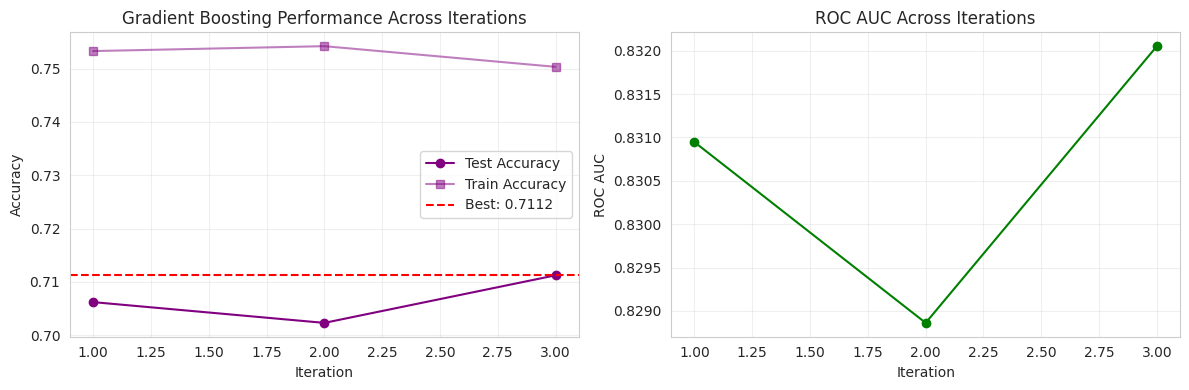


✅ Best Gradient Boosting Model Selected!


In [10]:
# Train Gradient Boosting with multiple iterations
print("\n" + "="*60)
print("TRAINING GRADIENT BOOSTING (3 ITERATIONS)")
print("="*60)

n_iterations = 3
gb_results = []
best_gb_model = None
best_gb_score = 0

print(f"\n🔄 Training {n_iterations} different Gradient Boosting models...")
print("   Finding the best configuration through random seed variation\n")

# Progress bar for iterations
with tqdm(total=n_iterations, desc="GB Training", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
    for iteration in range(1, n_iterations + 1):
        # Train with different random seed
        gb_model = SafetyScoreModel(model_type='gradient_boost', random_state=iteration*42)
        gb_model.feature_names = feature_cols
        gb_metrics = gb_model.train(X, y, test_size=0.2, validate=True)
        
        # Track results
        gb_results.append({
            'iteration': iteration,
            'train_acc': gb_metrics['train_accuracy'],
            'test_acc': gb_metrics['test_accuracy'],
            'roc_auc': gb_metrics.get('roc_auc', 0),
            'cv_mean': gb_metrics.get('cv_mean', 0)
        })
        
        # Keep best model
        if gb_metrics['test_accuracy'] > best_gb_score:
            best_gb_score = gb_metrics['test_accuracy']
            best_gb_model = gb_model
            best_gb_metrics = gb_metrics
            pbar.set_postfix_str(f"✨ Best: {best_gb_score:.4f}")
        else:
            pbar.set_postfix_str(f"Current: {gb_metrics['test_accuracy']:.4f}")
        
        pbar.update(1)

# Show results summary
gb_results_df = pd.DataFrame(gb_results)
print(f"\n📊 Gradient Boosting Training Summary:")
print(f"   Best Test Accuracy: {best_gb_score:.4f} (Iteration {gb_results_df.loc[gb_results_df['test_acc'].idxmax(), 'iteration']:.0f})")
print(f"   Mean Test Accuracy: {gb_results_df['test_acc'].mean():.4f} (±{gb_results_df['test_acc'].std():.4f})")
print(f"   Best ROC AUC: {best_gb_metrics.get('roc_auc', 'N/A')}")

# Plot performance across iterations
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(gb_results_df['iteration'], gb_results_df['test_acc'], marker='o', label='Test Accuracy', color='purple')
plt.plot(gb_results_df['iteration'], gb_results_df['train_acc'], marker='s', alpha=0.5, label='Train Accuracy', color='purple')
plt.axhline(y=best_gb_score, color='r', linestyle='--', label=f'Best: {best_gb_score:.4f}')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting Performance Across Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(gb_results_df['iteration'], gb_results_df['roc_auc'], marker='o', color='green')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Across Iterations')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Best Gradient Boosting Model Selected!")

## 6. Compare Models


FINAL MODEL COMPARISON (Best of 20 Iterations Each)
            Model  Train Accuracy  Test Accuracy  ROC AUC  CV Mean  Best Iteration
    Random Forest        0.728877       0.724550 0.835851 0.720222               3
          XGBoost        0.756327       0.705649 0.829529 0.706878               1
Gradient Boosting        0.750327       0.711242 0.832053 0.711550               3

🏆 OVERALL WINNER: Random Forest
   Best iteration: 3/20
   Test Accuracy: 0.7246
   ROC AUC: 0.8359


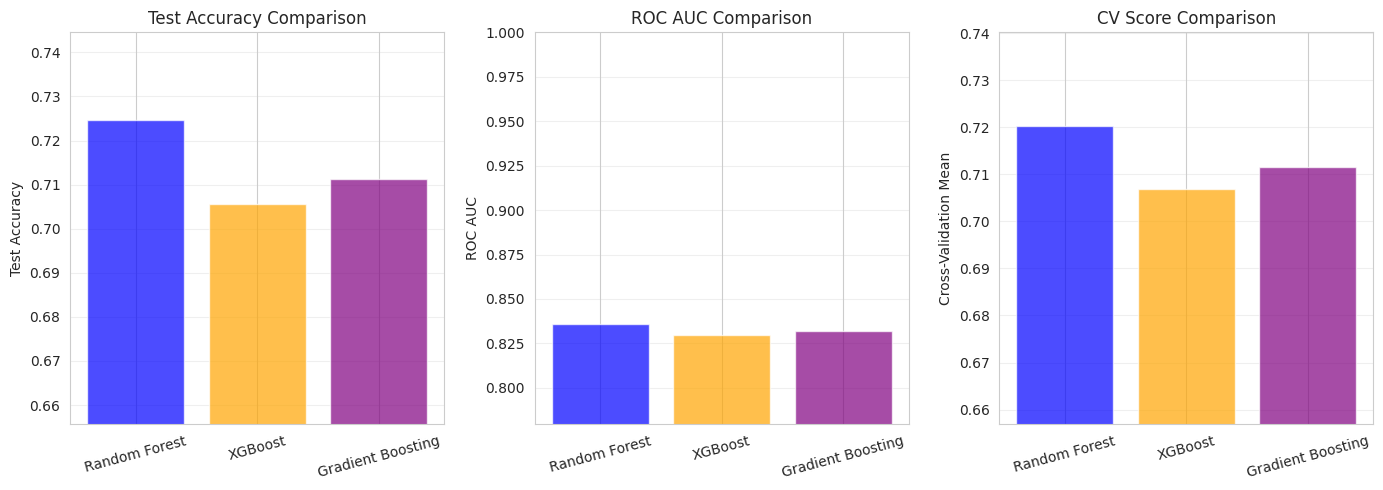


📊 Comparison chart saved to results/figures/model_comparison.png


In [11]:
# Model comparison - Compare the BEST of each model type
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'Train Accuracy': [best_rf_metrics['train_accuracy'], best_xgb_metrics['train_accuracy'], best_gb_metrics['train_accuracy']],
    'Test Accuracy': [best_rf_metrics['test_accuracy'], best_xgb_metrics['test_accuracy'], best_gb_metrics['test_accuracy']],
    'ROC AUC': [best_rf_metrics.get('roc_auc', 0), best_xgb_metrics.get('roc_auc', 0), best_gb_metrics.get('roc_auc', 0)],
    'CV Mean': [best_rf_metrics.get('cv_mean', 0), best_xgb_metrics.get('cv_mean', 0), best_gb_metrics.get('cv_mean', 0)],
    'Best Iteration': [
        rf_results_df.loc[rf_results_df['test_acc'].idxmax(), 'iteration'],
        xgb_results_df.loc[xgb_results_df['test_acc'].idxmax(), 'iteration'],
        gb_results_df.loc[gb_results_df['test_acc'].idxmax(), 'iteration']
    ]
})

print("\n" + "="*80)
print("FINAL MODEL COMPARISON (Best of 20 Iterations Each)")
print("="*80)
print(comparison.to_string(index=False))

# Select best overall model
best_idx = comparison['Test Accuracy'].idxmax()
best_model_name = comparison.loc[best_idx, 'Model']
best_iteration = comparison.loc[best_idx, 'Best Iteration']
print(f"\n🏆 OVERALL WINNER: {best_model_name}")
print(f"   Best iteration: {best_iteration:.0f}/20")
print(f"   Test Accuracy: {comparison.loc[best_idx, 'Test Accuracy']:.4f}")
print(f"   ROC AUC: {comparison.loc[best_idx, 'ROC AUC']:.4f}")

# Use best model for further analysis
if best_model_name == 'Random Forest':
    best_model = best_rf_model
    rf_model = best_rf_model
    rf_metrics = best_rf_metrics
elif best_model_name == 'XGBoost':
    best_model = best_xgb_model
    xgb_model = best_xgb_model
    xgb_metrics = best_xgb_metrics
else:
    best_model = best_gb_model
    gb_model = best_gb_model
    gb_metrics = best_gb_metrics

# Visualize comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.bar(comparison['Model'], comparison['Test Accuracy'], color=['blue', 'orange', 'purple'], alpha=0.7)
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.xticks(rotation=15)
plt.ylim([comparison['Test Accuracy'].min() - 0.05, comparison['Test Accuracy'].max() + 0.02])
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 3, 2)
plt.bar(comparison['Model'], comparison['ROC AUC'], color=['blue', 'orange', 'purple'], alpha=0.7)
plt.ylabel('ROC AUC')
plt.title('ROC AUC Comparison')
plt.xticks(rotation=15)
plt.ylim([comparison['ROC AUC'].min() - 0.05, 1.0])
plt.grid(True, alpha=0.3, axis='y')

plt.subplot(1, 3, 3)
plt.bar(comparison['Model'], comparison['CV Mean'], color=['blue', 'orange', 'purple'], alpha=0.7)
plt.ylabel('Cross-Validation Mean')
plt.title('CV Score Comparison')
plt.xticks(rotation=15)
plt.ylim([comparison['CV Mean'].min() - 0.05, comparison['CV Mean'].max() + 0.02])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Comparison chart saved to results/figures/model_comparison.png")

## 7. Feature Importance Analysis

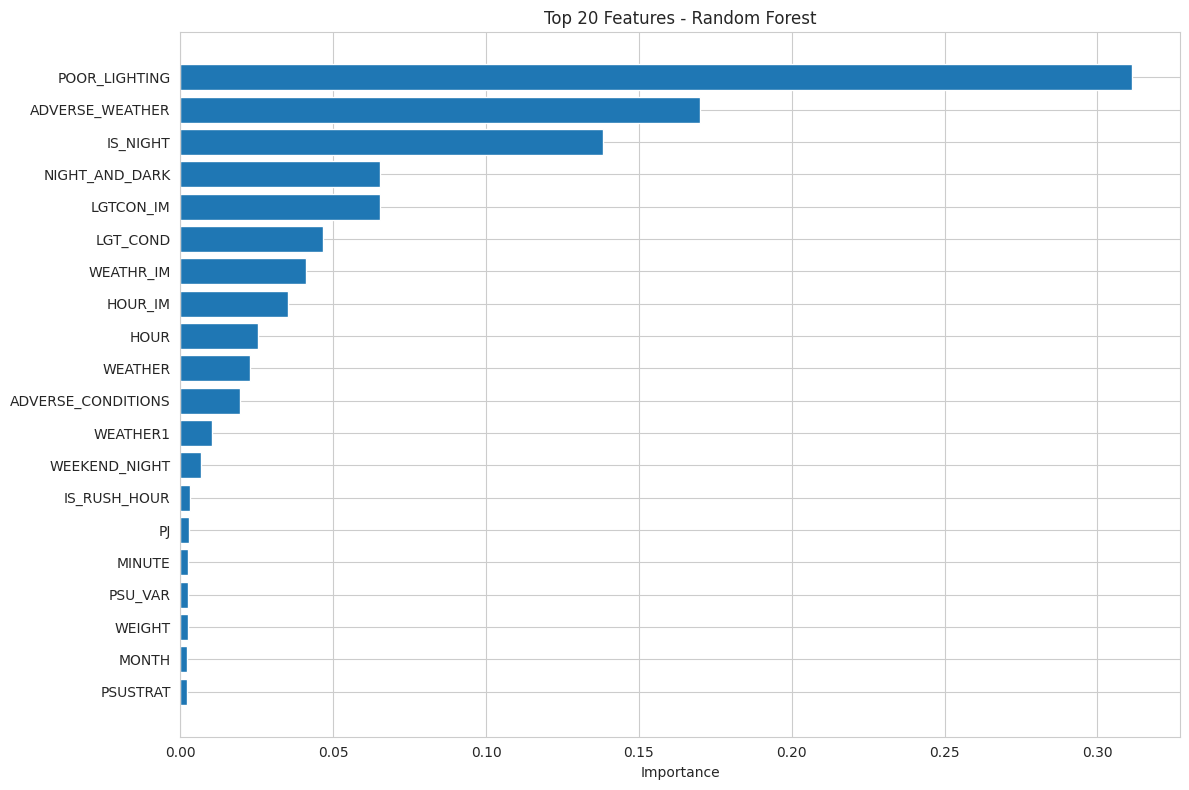


Top 20 Most Important Features:
           feature  importance
     POOR_LIGHTING    0.311448
   ADVERSE_WEATHER    0.170060
          IS_NIGHT    0.138153
    NIGHT_AND_DARK    0.065219
         LGTCON_IM    0.065212
          LGT_COND    0.046793
         WEATHR_IM    0.041049
           HOUR_IM    0.035226
              HOUR    0.025300
           WEATHER    0.022653
ADVERSE_CONDITIONS    0.019386
          WEATHER1    0.010412
     WEEKEND_NIGHT    0.006643
      IS_RUSH_HOUR    0.003280
                PJ    0.002938
            MINUTE    0.002643
           PSU_VAR    0.002606
            WEIGHT    0.002576
             MONTH    0.002323
          PSUSTRAT    0.002258


In [12]:
# Plot top 20 features
if best_model.feature_importance is not None:
    top_features = best_model.feature_importance.head(20)
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../results/figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 20 Most Important Features:")
    print(top_features.to_string(index=False))

## 8. Compute Safety Scores
## 
## Safety Score = Distance from decision boundary (0-100)
## Higher score = safer (further from crash conditions)

In [13]:
# Compute safety scores for all samples
safety_scores = best_model.predict_safety_score(X)

# Add to dataset
full_dataset['SAFETY_SCORE'] = safety_scores

print("Safety Score Statistics:")
print(full_dataset['SAFETY_SCORE'].describe())

# Compare scores for crash vs safe samples
print("\nSafety Score by Group:")
print(full_dataset.groupby('TARGET')['SAFETY_SCORE'].describe())

Safety Score Statistics:
count    70628.000000
mean        49.973625
std         24.049116
min          1.293229
25%         49.432810
50%         51.688642
75%         57.651310
max         99.480985
Name: SAFETY_SCORE, dtype: float64

Safety Score by Group:
          count       mean        std       min        25%        50%  \
TARGET                                                                  
0       35314.0  65.270268  17.479110  4.433208  51.645392  54.199124   
1       35314.0  34.676982  19.576241  1.293229  13.709005  50.629016   

              75%        max  
TARGET                        
0       76.734367  99.480985  
1       51.730122  75.856445  


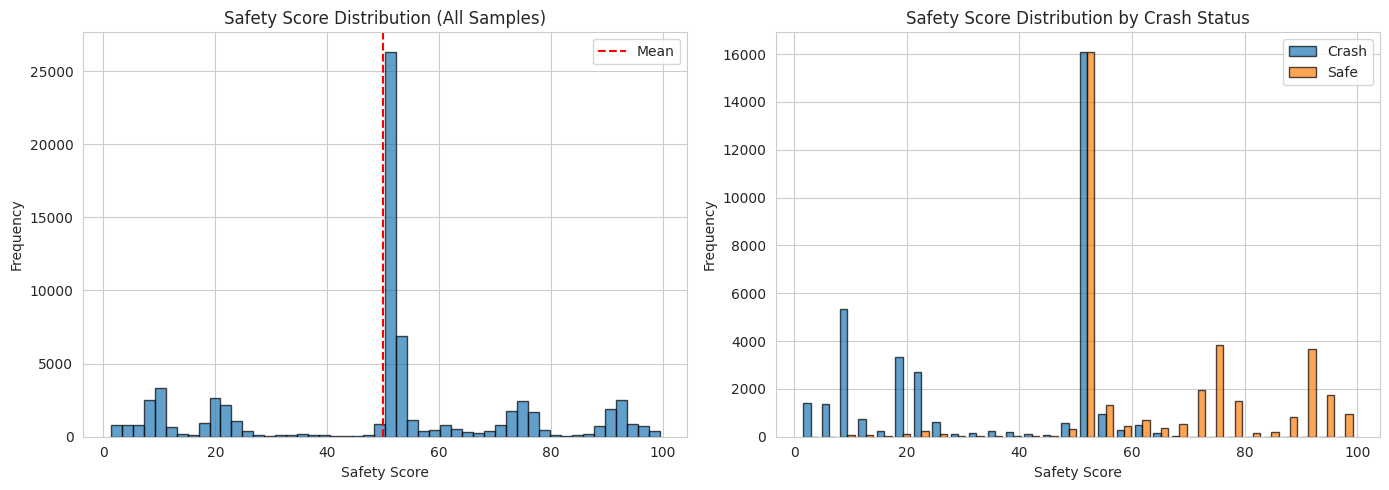

In [14]:
# Plot safety score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall distribution
axes[0].hist(full_dataset['SAFETY_SCORE'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Safety Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Safety Score Distribution (All Samples)')
axes[0].axvline(full_dataset['SAFETY_SCORE'].mean(), color='red', linestyle='--', label='Mean')
axes[0].legend()

# By crash status
crash_scores = full_dataset[full_dataset['TARGET'] == 1]['SAFETY_SCORE']
safe_scores = full_dataset[full_dataset['TARGET'] == 0]['SAFETY_SCORE']

axes[1].hist([crash_scores, safe_scores], bins=30, label=['Crash', 'Safe'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Safety Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Safety Score Distribution by Crash Status')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/figures/safety_score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Extract 'Good Driver Profile'
## 
## Identify conditions with highest safety scores

In [15]:
# Get top 10% safest samples
threshold_90 = full_dataset['SAFETY_SCORE'].quantile(0.90)
good_driver_samples = full_dataset[full_dataset['SAFETY_SCORE'] >= threshold_90]

print(f"Good Driver Profile (Top 10% Safety Scores)")
print(f"Threshold: {threshold_90:.2f}")
print(f"Number of samples: {len(good_driver_samples)}")

# Analyze characteristics
print("\nCharacteristics of Good Driver Profile:")

# Key binary features
binary_features = ['IS_NIGHT', 'IS_WEEKEND', 'IS_RUSH_HOUR', 'POOR_LIGHTING', 'ADVERSE_WEATHER']
for feat in binary_features:
    if feat in good_driver_samples.columns:
        pct = (good_driver_samples[feat] == 0).mean() * 100
        print(f"  {feat}: {pct:.1f}% favorable")

Good Driver Profile (Top 10% Safety Scores)
Threshold: 87.93
Number of samples: 7063

Characteristics of Good Driver Profile:
  IS_NIGHT: 98.9% favorable
  IS_WEEKEND: 67.8% favorable
  IS_RUSH_HOUR: 92.1% favorable
  POOR_LIGHTING: 100.0% favorable
  ADVERSE_WEATHER: 100.0% favorable


In [16]:
# Create good driver profile summary
good_driver_profile = {}

for col in feature_cols[:30]:  # Top 30 features
    if col in good_driver_samples.columns:
        good_driver_profile[col] = {
            'mean': good_driver_samples[col].mean(),
            'median': good_driver_samples[col].median(),
            'std': good_driver_samples[col].std()
        }

profile_df = pd.DataFrame(good_driver_profile).T
print("\nGood Driver Profile (Top 30 Features):")
print(profile_df.head(20))

# Save profile
profile_df.to_csv('../results/tables/good_driver_profile.csv')
print("\n✓ Good driver profile saved to results/tables/good_driver_profile.csv")


Good Driver Profile (Top 30 Features):
                   mean  median          std
PJ          1919.561518  1695.0  1503.427209
STRATUM        2.037095     2.0     0.502652
VE_TOTAL       1.090330     1.0     0.391131
VE_FORMS       1.052244     1.0     0.270236
PVH_INVL       0.038086     0.0     0.264686
PEDS           1.044315     1.0     0.311929
PERMVIT        1.274954     1.0     0.743331
PERNOTMVIT     1.058049     1.0     0.368353
NUM_INJ        1.102648     1.0     0.477559
MONTH          6.858276     7.0     3.452537
DAY_WEEK       4.127425     4.0     2.072507
HOUR          15.273113    20.0     8.471855
MINUTE        27.494691    28.0    17.658838
HARM_EV        8.661192     8.0     2.677149
ALCOHOL        5.518193     9.0     3.653333
MAX_SEV        2.228090     2.0     1.029964
MAN_COLL       0.098117     0.0     1.759507
RELJCT1        1.441031     0.0     3.044445
RELJCT2        6.622823     2.0    19.777383
TYP_INT        9.882911     1.0    27.082617

✓ Good driver 

## 10. Save Trained Model

In [ ]:
import joblib

# Save the underlying model (sklearn/xgboost model object)
# This avoids the pickling error from module reloading
model_path = '../results/models/best_safety_model.pkl'
joblib.dump(best_model.model, model_path)  # Save the underlying model, not the wrapper
print(f"✓ Model saved to {model_path}")

# Save the model type and configuration for later reconstruction
config_path = '../results/models/model_config.txt'
with open(config_path, 'w') as f:
    f.write(f"model_type: {best_model.model_type}\n")
    f.write(f"model_name: {best_model_name}\n")
    f.write(f"random_state: {best_model.random_state}\n")
print(f"✓ Model configuration saved to {config_path}")

# Save feature names
feature_path = '../results/models/feature_names.txt'
with open(feature_path, 'w') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")
print(f"✓ Feature names saved to {feature_path}")

# Save model comparison
comparison.to_csv('../results/tables/model_comparison.csv', index=False)
print("✓ Model comparison saved to results/tables/model_comparison.csv")

print("\n💡 Note: The underlying model is saved. To load it later:")
print("   model = joblib.load('best_safety_model.pkl')")
print("   wrapper = SafetyScoreModel(model_type='...')  # from config")
print("   wrapper.model = model")

PicklingError: Can't pickle <class 'models.SafetyScoreModel'>: it's not the same object as models.SafetyScoreModel

## Summary
## 
## ✅ Trained three models (RF, XGBoost, GB)
## ✅ Selected best model based on test accuracy
## ✅ Computed safety scores (0-100)
## ✅ Extracted good driver profile
## ✅ Saved model and results
## 
## Next Steps:
## - Implement real-time safety score calculator
## - Build interactive dashboard
## - Add SHAP analysis for interpretability